In [3]:
import numpy as np
import random
import scipy.linalg
import gym
from Utility import DerivativeLiftFunc, data_collecter,RBFLiftFunc

/home/stone/anaconda3/envs/mujoco/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [4]:
ENV = ["DampingPendulum","Pendulum-v1","CartPole-v1","MountainCarContinuous-v0","Reacher-v2","Franka"]

In [7]:
def evalKoopmanD(env_index):
    env_name = ENV[env_index]
    print(env_name)
    random.seed(1)
    np.random.seed(1)
    Data_collecter = data_collecter(env_name)
    Nstate = Data_collecter.Nstates
    udim = Data_collecter.udim
    Nrbf = 50
    LiftFunc = RBFLiftFunc(env_name,Nstate,udim,Nrbf,Data_collecter.observation_space)
    NKoopman = LiftFunc.NKoopman
    Samples = 5000
    Steps = 30
    train_data = Data_collecter.collect_koopman_data(20000,1)
    X_lift = LiftFunc.Psi_su(train_data[0,:,udim:],train_data[0,:,:udim])
    Y_lift = LiftFunc.Psi_su(train_data[1,:,udim:],train_data[0,:,:udim])
    XX = np.dot(X_lift.T,X_lift)
    XY = np.dot(X_lift.T,Y_lift)
    Kd = np.dot(scipy.linalg.pinv2(XX),XY).T  
    np.savez("Prediction_Results/"+"Kd_"+env_name+"_KoopmanRBF"+".npz",Kd=Kd,Center=LiftFunc.center)  
    times = 4 
    max_loss_all = np.zeros((times,Steps))
    mean_loss_all = np.zeros((times,Steps))
    for t in range(times):
        test_data = Data_collecter.collect_koopman_data(Samples,Steps)
        X_current = test_data[0,:,:]
        X_current_lift = np.zeros((Samples,NKoopman+udim))
        maxloss_list = []
        meanloss_list = []
        for i in range(Samples):
            X_current_lift[i] = LiftFunc.Psi_su(X_current[i,udim:],X_current[i,:udim])
        for i in range(Steps):
            X_current_lift = np.dot(X_current_lift,Kd.T)
            X_current_lift[:,NKoopman:] = test_data[i+1,:,:udim]
            Err = X_current_lift[:,:Nstate] - test_data[i+1,:,udim:]
            maxloss = np.mean(np.max(abs(Err),axis=0))
            meanloss = np.mean(np.mean(abs(Err),axis=0))
            maxloss_list.append(maxloss)
            meanloss_list.append(meanloss)
        max_loss_all[t] = np.array(maxloss_list).reshape(-1)
        mean_loss_all[t] = np.array(meanloss_list).reshape(-1)
    max_mean = np.mean(max_loss_all,axis=0)
    max_std = np.std(max_loss_all,axis=0)
    mean_mean =  np.mean(mean_loss_all,axis=0)
    mean_std =  np.std(mean_loss_all,axis=0)  
    np.save("Prediction_Results/"+env_name+"_KoopmanRBF"+".npy",np.array([max_mean,max_std,mean_mean,mean_std]))
    return max_mean,max_std,mean_mean,mean_std 

In [9]:
for j in range(6):
    evalKoopmanD(j)

DampingPendulum


/home/stone/anaconda3/envs/mujoco/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead


Pendulum-v1
CartPole-v1
MountainCarContinuous-v0
Reacher-v2
Franka


In [19]:
def evalKoopmanDMax(env_index):
    env_name = ENV[env_index]
    print(env_name)
    Data_collecter = data_collecter(env_name)
    Nstate = Data_collecter.Nstates
    udim = Data_collecter.udim
    Nrbf = 100
    LiftFunc = RBFLiftFunc(env_name,Nstate,udim,Nrbf,Data_collecter.observation_space)
    NKoopman = LiftFunc.NKoopman
    Samples = 20000
    Steps = 30
    train_data = Data_collecter.collect_koopman_data(20000,1)
    X_lift = LiftFunc.Psi_su(train_data[0,:,udim:],train_data[0,:,:udim])
    Y_lift = LiftFunc.Psi_su(train_data[1,:,udim:],train_data[0,:,:udim])
    XX = np.dot(X_lift.T,X_lift)
    XY = np.dot(X_lift.T,Y_lift)
    Kd = np.dot(scipy.linalg.pinv2(XX),XY).T    
    random.seed(2022)
    np.random.seed(2022)
    test_data = Data_collecter.collect_koopman_data(Samples,Steps)
    X_current = test_data[0,:,:]
    X_current_lift = np.zeros((Samples,NKoopman+udim))
    maxloss_list = []
    meanloss_list = []
    for i in range(Samples):
        X_current_lift[i] = LiftFunc.Psi_su(X_current[i,udim:],X_current[i,:udim])
    for i in range(Steps):
        X_current_lift = np.dot(X_current_lift,Kd.T)
        X_current_lift[:,NKoopman:] = test_data[i+1,:,:udim]
        Err = X_current_lift[:,:Nstate] - test_data[i+1,:,udim:]
        maxloss = np.max(abs(Err),axis=0)
        meanloss = np.mean(abs(Err),axis=0)
        maxloss_list.append(maxloss)
        meanloss_list.append(meanloss)
    max_loss_all = np.array(maxloss_list).reshape(Steps,Nstate)
    mean_loss_all = np.array(meanloss_list).reshape(Steps,Nstate)
    np.save("Prediction_ResultsMax/"+env_name+"_KoopmanRBF"+".npy",np.array([max_loss_all,mean_loss_all]))
    return max_loss_all,mean_loss_all

In [21]:
max_loss_all,mean_loss_all =  evalKoopmanDMax(0)

DampingPendulum


/home/stone/anaconda3/envs/mujoco/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead


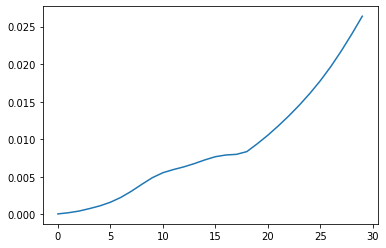

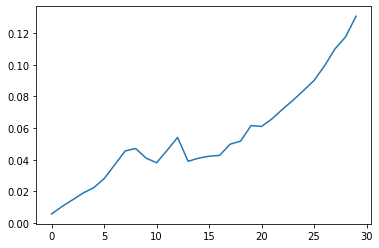

In [23]:
import matplotlib.pylab as plt
plt.plot(max_loss_all[:,0])
plt.show()
plt.plot(max_loss_all[:,1])
plt.show()

In [20]:
for j in range(4):
    evalKoopmanDMax(j)

DampingPendulum


/home/stone/anaconda3/envs/mujoco/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead


KeyboardInterrupt: 

In [16]:
for j in range(4):
     evalKoopmanD(j)

DampingPendulum


/home/stone/anaconda3/envs/mujoco/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead


Pendulum-v1
CartPole-v1
MountainCarContinuous-v0


In [10]:
env_name = "CartPole-v1"
Data_collecter = data_collecter(env_name)
Nstate = Data_collecter.Nstates
udim = Data_collecter.udim
Nrbf = 100
LiftFunc = RBFLiftFunc(env_name,Nstate,udim,Nrbf,Data_collecter.observation_space)
NKoopman = LiftFunc.NKoopman
Samples = 5000
Steps = 30
train_data = Data_collecter.collect_koopman_data(20000,1)

In [5]:
train_data[0,:,udim:].shape

(20000, 2)

In [13]:
X_lift = LiftFunc.Psi_su(train_data[0,:,udim:],train_data[0,:,:udim])
Y_lift = LiftFunc.Psi_su(train_data[1,:,udim:],train_data[0,:,:udim])
XX = np.dot(X_lift.T,X_lift)
XY = np.dot(X_lift.T,Y_lift)
Kd = np.dot(scipy.linalg.pinv2(XX),XY).T
local_errors = abs(Y_lift- np.dot(X_lift,Kd.T))
max_local_errors = np.amax(local_errors, axis = 0)
print("max err:",max_local_errors)

max err: [1.25026662e-06 2.37903949e-05 5.92017828e-06 2.79197586e-04
 2.81929065e-01 4.58707336e-01 3.60270568e-01 4.50731634e-01
 3.09951485e-01 3.02679001e-01 3.65000869e-01 3.38358392e-01
 3.01254958e-01 3.76671753e-01 3.18364605e-01 3.88824353e-01
 3.51702819e-01 3.90187089e-01 2.71751648e-01 4.54038146e-01
 4.39999269e-01 3.85287076e-01 2.42547651e-01 3.31467354e-01
 3.28083821e-01 4.01025148e-01 3.61843778e-01 2.85567480e-01
 3.16808843e-01 4.04619462e-01 2.66717742e-01 3.71463044e-01
 3.17670685e-01 3.67772422e-01 4.07013852e-01 4.03475702e-01
 2.71514121e-01 4.21659785e-01 3.33627610e-01 5.04353788e-01
 3.60406969e-01 2.58012976e-01 3.21236761e-01 3.42057046e-01
 3.21532680e-01 4.19753519e-01 3.03042141e-01 4.34039967e-01
 4.44342262e-01 3.01756745e-01 4.78227061e-01 4.18435737e-01
 3.53974310e-01 2.10253754e-01 3.70549169e-01 3.62969222e-01
 4.43670817e-01 4.13737693e-01 3.04674108e-01 3.14981216e-01
 2.89507047e-01 2.80051835e-01 2.49503789e-01 4.33161561e-01
 4.43365487e-01

/home/stone/anaconda3/envs/mujoco/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.linalg.pinv2 is deprecated since SciPy 1.7.0, use scipy.linalg.pinv instead
  """


In [14]:
test_data = Data_collecter.collect_koopman_data(Samples,Steps)
X_current = test_data[0,:,:]
X_current_lift = LiftFunc.Psi_su(X_current[:,udim:],X_current[:,:udim])
maxloss_list = []
meanloss_list = []
for i in range(Steps-1):
    X_current_lift = np.dot(X_current_lift,Kd.T)
    X_current_lift[:,NKoopman:] = test_data[i+1,:,:udim]
    Err = X_current_lift[:,:Nstate] - test_data[i+1,:,udim:]
    maxloss = np.mean(np.max(abs(Err),axis=0))
    meanloss = np.mean(np.mean(abs(Err),axis=0))
    maxloss_list.append(maxloss)
    meanloss_list.append(meanloss)
print(maxloss_list)

[7.334617651647696e-05, 0.00012119693130251716, 0.00021365338458725555, 0.00040474960468207376, 0.0007135542404852879, 0.0012540413994875932, 0.0020370609592137504, 0.003078555943712088, 0.004275810097803184, 0.006451988908515324, 0.008129235428477426, 0.011401034886597196, 0.016520090036860918, 0.020142624157188788, 0.029760201213041994, 0.04587552965373076, 0.061420688405664434, 0.08704520893892159, 0.11396591786717924, 0.16302386448786402, 0.21721111783373004, 0.29009210670574054, 0.4035984540418559, 0.5449690998552803, 0.7811834541202807, 1.0838213470300415, 1.4198609934463502, 1.9765330999032156, 2.7130266843897966]
